In [23]:
# Cell 1: Imports & data loading (same as before)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from sklearn.isotonic import IsotonicRegression

from utils.pred_crop import predict_with_uncertainty, label_encoder

df = pd.read_csv('data/Crop_recommendation.csv')
feature_cols = ['N','P','K','temperature','humidity','ph','rainfall']
X = df[feature_cols].values
y = label_encoder.transform(df['label'].values)
class_names = label_encoder.classes_

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [24]:
# Cell 2: Get raw probs on validation set & fit one IsotonicReg per class
N_SAMPLES = 20
probs_val = np.stack([
    predict_with_uncertainty(x, n_samples=N_SAMPLES)[0]
    for x in X_val
], axis=0)

# Fit calibrators
calibrators = []
for i, cls in enumerate(class_names):
    iso = IsotonicRegression(out_of_bounds='clip')
    y_bin = (y_val == i).astype(int)
    iso.fit(probs_val[:, i], y_bin)
    calibrators.append(iso)


In [25]:
# Cell 3: Apply calibrators on the original test set
# First recompute raw probs on X_test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
probs_test = np.stack([
    predict_with_uncertainty(x, n_samples=N_SAMPLES)[0]
    for x in X_test
], axis=0)

# Calibrated probabilities
probs_cal = np.zeros_like(probs_test)
for i, iso in enumerate(calibrators):
    probs_cal[:, i] = iso.predict(probs_test[:, i])
# Renormalize if you want them to still sum to 1:
probs_cal = probs_cal / probs_cal.sum(axis=1, keepdims=True)

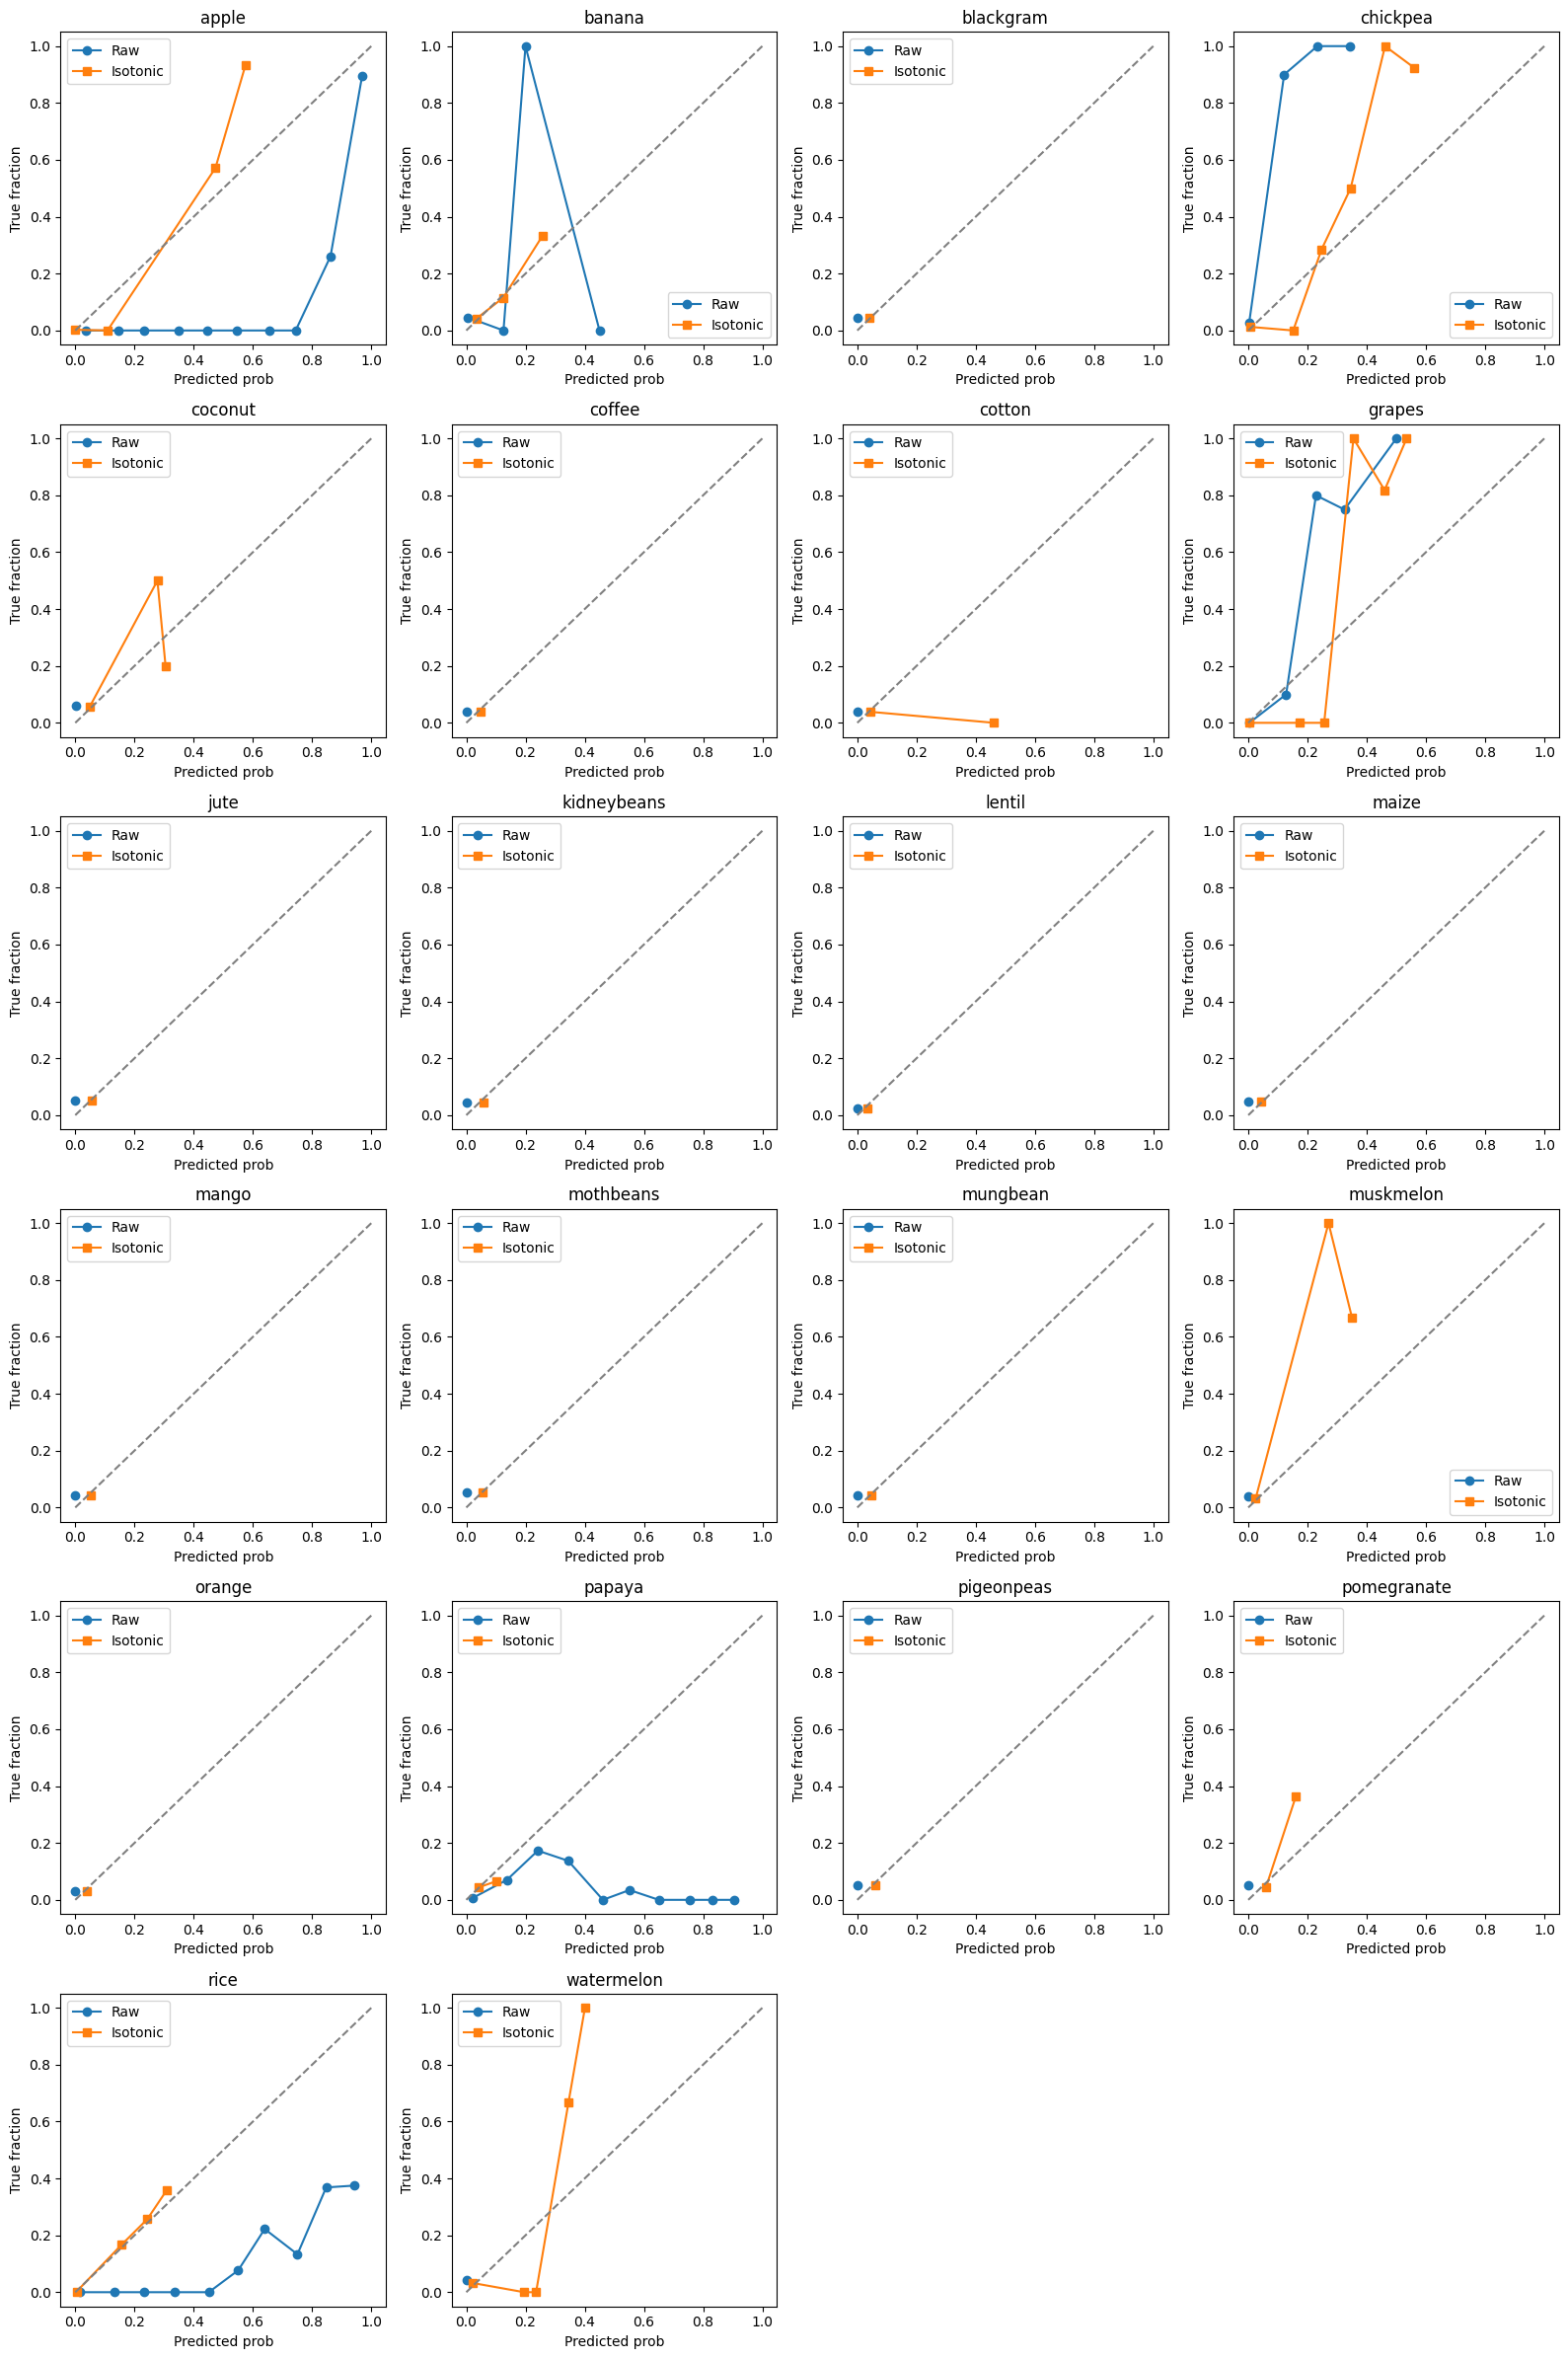

In [26]:
# Cell 4: Re-plot grid of reliability diagrams *after* calibration
n_classes = len(class_names)
ncols = 4
nrows = int(np.ceil(n_classes / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))
axes = axes.flatten()

for i, cls in enumerate(class_names):
    # before
    y_true_bin = (y_test == i).astype(int)
    y_prob_raw   = probs_test[:, i]
    prob_true_r, prob_pred_r = calibration_curve(y_true_bin, y_prob_raw, n_bins=10)
    # after
    y_prob_cal   = probs_cal[:, i]
    prob_true_c, prob_pred_c = calibration_curve(y_true_bin, y_prob_cal, n_bins=10)

    ax = axes[i]
    ax.plot(prob_pred_r, prob_true_r, 'o-', label='Raw')
    ax.plot(prob_pred_c, prob_true_c, 's-', label='Isotonic')
    ax.plot([0,1],[0,1],'--', color='gray')
    ax.set_title(f'{cls}')
    ax.set_xlabel('Predicted prob')
    ax.set_ylabel('True fraction')
    ax.legend()

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [27]:
import numpy as np

def compute_ece(probs, labels, n_bins=10):
    """
    Compute Expected Calibration Error (ECE) for a multi-class classifier.
    
    Arguments:
    ─ probs : np.ndarray, shape (n_samples, n_classes)
        The model’s predicted probabilities (e.g. the mean from MC-Dropout).
    ─ labels : np.ndarray, shape (n_samples,)
        The true class indices (0…n_classes-1).
    ─ n_bins : int
        Number of equally-spaced probability bins (default=10).
    
    Returns:
    ─ ece : float
        The ECE score: weighted average |conf(bin) – acc(bin)|.
    """
    # 1. For each sample, get its confidence and correctness
    confidences = np.max(probs, axis=1)
    predictions = np.argmax(probs, axis=1)
    correctness = (predictions == labels).astype(int)
    
    # 2. Bin boundaries
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    bin_lowers = bins[:-1]
    bin_uppers = bins[1:]
    
    ece = 0.0
    n = len(labels)
    
    # 3. Compute per-bin accuracy and confidence
    for lower, upper in zip(bin_lowers, bin_uppers):
        # select samples whose confidence falls into this bin (right-exclusive)
        in_bin = (confidences > lower) & (confidences <= upper)
        prop_in_bin = in_bin.mean()
        if prop_in_bin > 0:
            acc_in_bin = correctness[in_bin].mean()
            conf_in_bin = confidences[in_bin].mean()
            ece += prop_in_bin * abs(conf_in_bin - acc_in_bin)
    
    return ece

# ===== Example usage in your notebook =====
import pandas as pd
from sklearn.model_selection import train_test_split
from utils.pred_crop import predict_with_uncertainty, label_encoder

# Load & split
df = pd.read_csv('data/Crop_recommendation.csv')
X = df[['N','P','K','temperature','humidity','ph','rainfall']].values
y = label_encoder.transform(df['label'])
_, X_test, _, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Get raw MC-Dropout probabilities
probs_test = np.stack([
    predict_with_uncertainty(x, n_samples=20)[0]
    for x in X_test
], axis=0)

# Compute ECE before calibration
ece_raw = compute_ece(probs_test, y_test, n_bins=10)
print(f"ECE (raw): {ece_raw:.4f}")


# If you have calibrated probabilities (probs_cal), you can also do:
ece_cal = compute_ece(probs_cal, y_test, n_bins=10)
print(f"ECE (calibrated): {ece_cal:.4f}")


ECE (raw): 0.5519
ECE (calibrated): 0.0669
